# Imports & Notes

In [1]:
import numpy as np                          # linear algebra 
import pandas as pd                         # data processing    
import matplotlib.pyplot as plt             # data plotting
from sklearn.linear_model import Lasso      # Lasso regression from sklearn
from sklearn.linear_model import LassoCV    

# For numeric stability / reproducibility
np.random.seed(42)

# Reading Data

In [2]:
# 1) Read CSV
df = pd.read_csv("California_Houses.csv")

# 2) Target and features
target_col = "Median_House_Value"
y_all = df[target_col].values.astype(float)
X_all = df.drop(columns=[target_col]).values.astype(float)

# 3) Print summary
print("Samples:", X_all.shape[0], "Features:", X_all.shape[1])
print("Data shape:", df.shape)

# 4) Show first 5 rows as a table
print("\nFirst 5 rows:")
df.head()

Samples: 20640 Features: 13
Data shape: (20640, 14)

First 5 rows:


,Median_House_Value,Median_Income,Median_Age,Tot_Rooms,Tot_Bedrooms,Population,Households,Latitude,Longitude,Distance_to_coast,Distance_to_LA,Distance_to_SanDiego,Distance_to_SanJose,Distance_to_SanFrancisco
0,452600.0,8.3252,41,880,129,322,126,37.88,-122.23,9263.040773,556529.158342,735501.806984,67432.517001,21250.213767
1,358500.0,8.3014,21,7099,1106,2401,1138,37.86,-122.22,10225.733072,554279.850069,733236.884360,65049.908574,20880.600400
2,352100.0,7.2574,52,1467,190,496,177,37.85,-122.24,8259.085109,554610.717069,733525.682937,64867.289833,18811.487450
3,341300.0,5.6431,52,1274,235,558,219,37.85,-122.25,7768.086571,555194.266086,734095.290744,65287.138412,18031.047568
4,342200.0,3.8462,52,1627,280,565,259,37.85,-122.25,7768.086571,555194.266086,734095.290744,65287.138412,18031.047568


# Shuffle & split manually (70 / 15 / 15)

In [3]:
n = X_all.shape[0]                          # n = total number of samples(houses)
indices = np.random.permutation(n)          # random shuffle of indices

n_train = int(0.70 * n)                     # 70% training
n_val   = int(0.15 * n)                     # 15% validation
# rest -> test           
                 
train_idx = indices[:n_train]
val_idx   = indices[n_train:n_train+n_val]
test_idx  = indices[n_train+n_val:]

X_train = X_all[train_idx]                  # feature values for training set
y_train = y_all[train_idx]                  # target values(Median_House_Value) for training set

X_val = X_all[val_idx]
y_val = y_all[val_idx]

X_test = X_all[test_idx]
y_test = y_all[test_idx]

print(X_train.shape, X_val.shape, X_test.shape)

(14447, 13) (3096, 13) (3097, 13)


# Feature scaling (Data is scaled properly: mean ≈ 0, std ≈ 1)

In [ ]:
# Compute mean/std on training set only
X_mean = X_train.mean(axis=0)
X_std  = X_train.std(axis=0)
# avoid divide-by-zero
X_std[X_std == 0] = 1.0

def standardize(X, mean=X_mean, std=X_std):                     
    return (X - mean) / std                             # Standardization (z-score normalization) -> can be -ve

X_train_s = standardize(X_train)
X_val_s   = standardize(X_val)
X_test_s  = standardize(X_test)

# Add bias column (intercept)
def add_bias(X):
    return np.c_[np.ones((X.shape[0], 1)), X]

X_train_b = add_bias(X_train_s)
X_val_b   = add_bias(X_val_s)
X_test_b  = add_bias(X_test_s)

# Check shapes after bias addition
print("Train shape:", X_train_b.shape)                   # Original number of features + 1 for bias
print("Validation shape:", X_val_b.shape)
print("Test shape:", X_test_b.shape)

# Show one example before/after scaling
print("\nBefore scaling (first feature of first sample):", X_train[0][2])
print("After scaling  (first feature of first sample):", X_train_s[0][2])

# Show the bias column (should be all 1s)
print("\nFirst 5 bias values in training set:", X_train_b[:5, 0])

Train shape: (14447, 14)
Validation shape: (3096, 14)
Test shape: (3097, 14)

Before scaling (first feature of first sample): 1505.0
After scaling  (first feature of first sample): -0.5124530213715498

First 5 bias values in training set: [1. 1. 1. 1. 1.]


# Utility functions: MSE, MAE

In [5]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)          # np.mean -> takes the average of all squared errors.

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))         # y_true - y_pred: computes the error (difference) for each sample.
                                                    # np.abs -> computes the absolute difference (ignores sign).
# Example true vs predicted values
y_true = np.array([3, -0.5, 2, 7])
y_pred = np.array([2.5, 0.0, 2, 8])

print("MSE test value:", mse(y_true, y_pred))       # Lower MSE = better model (predictions closer to true values).
print("MAE test value:", mae(y_true, y_pred))

MSE test value: 0.375
MAE test value: 0.5


# Linear Regression: Normal Equation (closed form)

In [ ]:
def linear_normal_equation(X, y):               # X: feature matrix of shape (n_samples, n_features), each row = one data point, each column = one feature / y: target vector (true output values)
    w = np.linalg.pinv(X.T @ X) @ X.T @ y       # @ → matrix multiplication 
    return w                                    # weights vector of shape (n_features)

w_ne = linear_normal_equation(X_train_b, y_train)
# Predictions on validation set
y_val_pred_ne = X_val_b @ w_ne                  
print("Validation MSE:", mse(y_val, y_val_pred_ne))
print("Validation MAE:", mae(y_val, y_val_pred_ne))
# Predictions on test set
y_test_pred_ne = X_test_b @ w_ne              
print("Test MSE:", mse(y_test, y_test_pred_ne))
print("Test MAE:", mae(y_test, y_test_pred_ne))

Validation MSE: 4575337829.500232
Validation MAE: 49755.4666997863
Test MSE: 5118393516.118098
Test MAE: 50973.34961075813


# Linear Regression: Gradient Descent (batch)

In [ ]:
# just like with the normal equation, but iteratively instead of using a direct formula.
def gradient_descent(X, y, lr=0.01, n_iter=10000, tol=1e-8, verbose=False):  # lr: learning rate, n_iter: max iterations, tol: tolerance
    n_samples, n_features = X.shape
    w = np.zeros(n_features)                                                 # start all weights at zero.
    prev_loss = float("inf")                                                 # Keeps track of previous iteration’s loss to detect when to stop (early stopping).
    for it in range(n_iter):                                                 # Loop through up to n_iter iterations, updating weights each time.
        y_pred = X @ w
        error = y_pred - y
        loss = np.mean(error ** 2)
        grad = (2.0 / n_samples) * (X.T @ error)                             # gradient of MSE w.r.t w
        w -= lr * grad
        if verbose and (it % (n_iter // 10 + 1) == 0):                       # If verbose=True, prints the current iteration number and loss every few steps.
            print(f"iter {it}, loss {loss:.5f}")
        if abs(prev_loss - loss) < tol:
            break
        prev_loss = loss
    return w

# Example training 
w_gd = gradient_descent(X_train_b, y_train, lr=0.01, n_iter=20000, tol=1e-9)
# Predict on validation set
y_val_pred_gd = X_val_b @ w_gd
print("Validation MSE:", mse(y_val, y_val_pred_gd))
print("Validation MAE:", mae(y_val, y_val_pred_gd))
# Predict on test set
y_test_pred_gd = X_test_b @ w_gd 
print("Test MSE:", mse(y_test, y_test_pred_gd))
print("Test MAE:", mae(y_test, y_test_pred_gd))

Validation MSE: 4590094260.538779
Validation MAE: 49907.15842367187
Test MSE: 5117119258.145263
Test MAE: 51003.71532629396


# Ridge Regression (L2 Regularization) - Closed Form

Ridge MSE (λ=1.0): 4575900828.46942
Ridge MAE (λ=1.0): 49763.59292706879


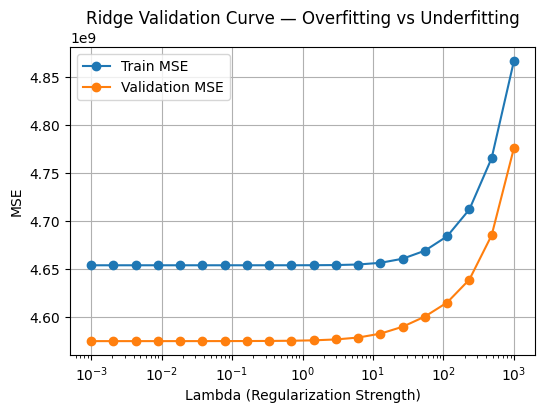

Best λ for Ridge: 0.001


In [8]:
def ridge_closed_form(X, y, lam):
    n_features = X.shape[1]
    I = np.eye(n_features)
    I[0, 0] = 0             # do not regularize bias
    w = np.linalg.pinv(X.T @ X + lam * I) @ X.T @ y
    return w

# Try example lambda
lam = 1.0
w_ridge = ridge_closed_form(X_train_b, y_train, lam)
print("Ridge MSE (λ=1.0):", mse(y_val, X_val_b @ w_ridge))
print("Ridge MAE (λ=1.0):", mae(y_val, X_val_b @ w_ridge))

# Validation Curve
lambdas = np.logspace(-3, 3, 20)  # test 20 values between 0.001 and 1000
ridge_val_mse = []
ridge_train_mse = []

for lam in lambdas:
    w_ridge = ridge_closed_form(X_train_b, y_train, lam)
    y_val_pred = X_val_b @ w_ridge
    ridge_val_mse.append(mse(y_val, y_val_pred))
    y_train_pred = X_train_b @ w_ridge
    ridge_train_mse.append(mse(y_train, y_train_pred))

# Plot train and validation MSE vs lambda
plt.figure(figsize=(6,4))
plt.plot(lambdas, ridge_train_mse, label='Train MSE', marker='o')
plt.plot(lambdas, ridge_val_mse, label='Validation MSE', marker='o')
plt.xscale('log')
plt.xlabel('Lambda (Regularization Strength)')
plt.ylabel('MSE')
plt.title('Ridge Validation Curve — Overfitting vs Underfitting')
plt.legend()
plt.grid(True)
plt.show()

# Find best lambda
best_lam_ridge = lambdas[np.argmin(ridge_val_mse)]
print("Best λ for Ridge:", best_lam_ridge)


# Lasso Regression (L1)

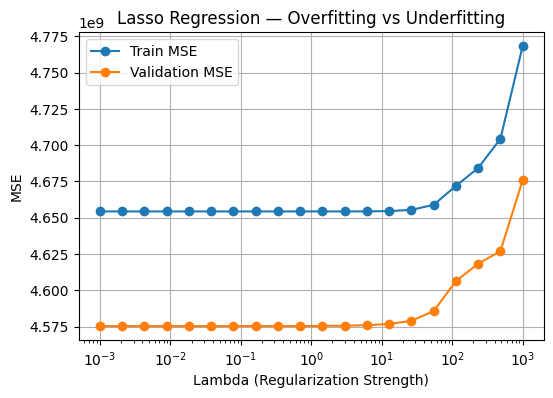

Best λ for Lasso: 0.001
Lasso MSE (λ=0.001): 4575337921.685766
Lasso MAE (λ=0.001): 49755.46804220087


In [9]:
# Regularization values (λ)
lambdas = np.logspace(-3, 3, 20)   # from 0.001 → 1000
lasso_train_mse = []
lasso_val_mse = []

for lam in lambdas:
    lasso_model = Lasso(alpha=lam, max_iter=10000)
    lasso_model.fit(X_train_b[:, 1:], y_train)     

    # Predictions
    y_train_pred = lasso_model.predict(X_train_b[:, 1:])
    y_val_pred = lasso_model.predict(X_val_b[:, 1:])

    # Compute MSEs
    lasso_train_mse.append(mse(y_train, y_train_pred))
    lasso_val_mse.append(mse(y_val, y_val_pred))

# Plot training vs validation MSE 
plt.figure(figsize=(6,4))
plt.plot(lambdas, lasso_train_mse, label='Train MSE', marker='o')
plt.plot(lambdas, lasso_val_mse, label='Validation MSE', marker='o')
plt.xscale('log')
plt.xlabel('Lambda (Regularization Strength)')
plt.ylabel('MSE')
plt.title('Lasso Regression — Overfitting vs Underfitting')
plt.legend()
plt.grid(True)
plt.show()

# Find the best lambda 
best_lam_lasso = lambdas[np.argmin(lasso_val_mse)]
print("Best λ for Lasso:", best_lam_lasso)

# Evaluate Lasso using best lambda (like Ridge)
best_lasso = Lasso(alpha=best_lam_lasso, max_iter=20000)
best_lasso.fit(X_train_b[:, 1:], y_train)

# Validation predictions
y_val_pred_lasso = best_lasso.predict(X_val_b[:, 1:])

# Compute and print MSE / MAE
print(f"Lasso MSE (λ={best_lam_lasso:.3g}):", mse(y_val, y_val_pred_lasso))
print(f"Lasso MAE (λ={best_lam_lasso:.3g}):", mae(y_val, y_val_pred_lasso))


# Final training & test evaluation


Test set performance (retrained on train+val where applicable):
                            Test_MSE      Test_MAE
Model                                             
NormalEqn               5.128255e+09  50966.364978
GradientDescent         5.125018e+09  50943.736275
Ridge (λ=0.001)         5.128255e+09  50966.361674
SklearnLasso (λ=0.001)  5.128255e+09  50966.364448


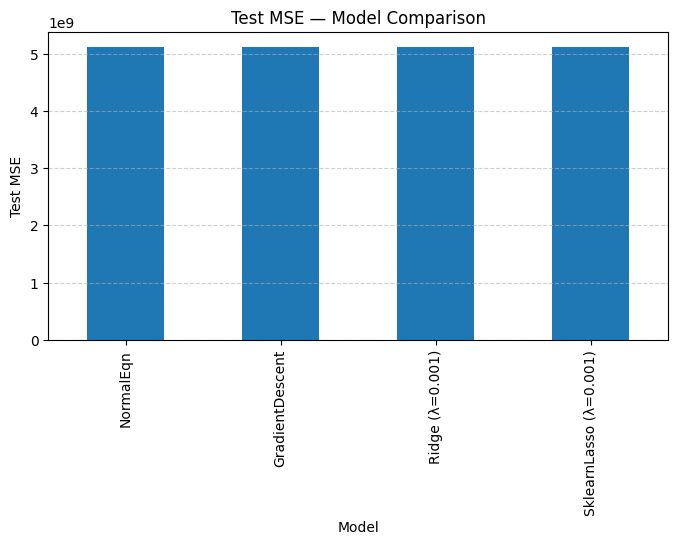

In [11]:
# Combine train + val for final retraining
X_comb_b = np.vstack([X_train_b, X_val_b])       # with bias
y_comb   = np.concatenate([y_train, y_val])

# Retrain all regression models on combined
final_w_ne = linear_normal_equation(X_comb_b, y_comb)

final_w_gd = gradient_descent(X_comb_b, y_comb, lr=0.01, n_iter=30000, tol=1e-9, verbose=False)

final_w_ridge = ridge_closed_form(X_comb_b, y_comb, best_lam_ridge)

sk_lasso = Lasso(alpha=best_lam_lasso, max_iter=20000)
sk_lasso.fit(X_comb_b[:, 1:], y_comb)

# Build weight vector with intercept first to be consistent with others
final_w_sklearn_lasso = np.concatenate(([sk_lasso.intercept_], sk_lasso.coef_))

# Evaluate all models on test set
models = {
    "NormalEqn": final_w_ne,
    "GradientDescent": final_w_gd,
    f"Ridge (λ={best_lam_ridge:.3g})": final_w_ridge,
    f"SklearnLasso (λ={best_lam_lasso:.3g})": final_w_sklearn_lasso
}

results = []
for name, w in models.items():
    y_test_pred = X_test_b @ w
    results.append({
        "Model": name,
        "Test_MSE": mse(y_test, y_test_pred),
        "Test_MAE": mae(y_test, y_test_pred)
    })

results_df = pd.DataFrame(results).set_index("Model")
print("\nTest set performance (retrained on train+val where applicable):")
print(results_df)

# Simple bar plot of Test MSE comparison
plt.figure(figsize=(8,4))
results_df["Test_MSE"].plot(kind='bar')
plt.ylabel("Test MSE")
plt.title("Test MSE — Model Comparison")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()